In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ReLU
from tensorflow.keras.layers import Activation

1.15.2


In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


4423680/4422102 [==============================] - 0s 0us/step


In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [4]:
#data exploration

print(train_images.shape)
print(len(train_labels))
print(train_labels)
print(test_images.shape)
print(len(test_labels))


(60000, 28, 28)
60000
[9 0 0 ... 3 0 5]
(10000, 28, 28)
10000


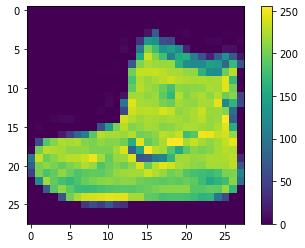

In [5]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()


In [6]:
#normalize data
train_images = train_images / 255.0

test_images = test_images / 255.0


In [7]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [9]:
model.fit(train_images, train_labels, epochs=10)


Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 95us/sample - loss: 0.4963 - acc: 0.8258
Epoch 2/10
60000/60000 [==============================] - 5s 78us/sample - loss: 0.3750 - acc: 0.8643
Epoch 3/10
60000/60000 [==============================] - 5s 75us/sample - loss: 0.3384 - acc: 0.8773
Epoch 4/10
60000/60000 [==============================] - 5s 77us/sample - loss: 0.3133 - acc: 0.8844
Epoch 5/10
60000/60000 [==============================] - 4s 75us/sample - loss: 0.2962 - acc: 0.8914
Epoch 6/10
60000/60000 [==============================] - 5s 79us/sample - loss: 0.2801 - acc: 0.8968
Epoch 7/10
60000/60000 [==============================] - 5s 90us/sample - loss: 0.2692 - acc: 0.8994
Epoch 8/10
60000/60000 [==============================] - 5s 78us/sample - loss: 0.2578 - acc: 0.9042
Epoch 9/10
60000/60000 [==============================] - 5s 78us/sample - loss: 0.2491 - acc: 0.9071
Epoch 10/10
60000/60000 [==============================] - 

In [10]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)


10000/10000 - 0s - loss: 0.3256 - acc: 0.8867

Test accuracy: 0.8867


Part 2: Secure Model Training with Syft Keras

In this notebook, we want to benchmark the additional time required to train an encrypted model securely using the SecureNN protocol over a normal tensorflow training.

To secure and train this model, we will need three TFEWorkers (servers). This is because TF Encrypted under the hood uses an encryption technique called multi-party computation (MPC). The idea is to split the model weights and input data into shares, then send a share of each value to the different servers. The key property is that if you look at the share on one server, it reveals nothing about the original value (input data or model weights).

We'll define a Syft Keras model like we did in the previous notebook. However, there is a trick: before instantiating this model, we'll run hook = sy.KerasHook(tf.keras). This will add three important new methods to the Keras Sequential class:

<ol>
    <li>
share: will secure your model via secret sharing; by default, it will use the SecureNN protocol from TF Encrypted to secret share your model between each of the three TFEWorkers. Most importantly, this will add the capability of providing predictions on encrypted data.
    </li>
    <li>
serve: this function will launch a serving queue, so that the TFEWorkers can accept prediction requests on the secured model from external clients.
    </li>
    <li>
shutdown_workers: once you are done providing private predictions, you can shut down your model by running this function. It will direct you to shutdown the server processes manually if you've opted to manually manage each worker.
If you want to learn more about MPC, you can read this excellent blog.
    </li>
</ol>

In [12]:
import syft as sy
hook = sy.KerasHook(tf.keras)

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'F:\Anaconda3\envs\tfe\lib\site-packages\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.2.so'


In [13]:
#using private tensorflow
##helper functions

def encode_image(value):
    """Encode images into a tf.train.Feature for a TFRecord."""
    bytes_list = tf.train.BytesList(value=[value.tostring()])
    return tf.train.Feature(bytes_list=bytes_list)


def decode_image(value):
    """Decode the image from a tf.train.Feature in a TFRecord."""
    image = tf.decode_raw(value, tf.uint8)
    image.set_shape((28 * 28))
    return image


def encode_label(value):
    """Encode a label into a tf.train.Feature for a TFRecord."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def decode_label(value):
    """Decode the label from a tf.train.Feature in a TFRecord."""
    return tf.cast(value, tf.int32)


def encode(image, label):
    """Encode an instance as a tf.train.Example for a TFRecord."""
    feature_dict = {'image': encode_image(image), 'label': encode_label(label)}
    features = tf.train.Features(feature=feature_dict)
    return tf.train.Example(features=features)


def decode(serialized_example):
    """Decode an instance from a tf.train.Example in a TFRecord."""
    features = tf.parse_single_example(serialized_example, features={
      'image': tf.FixedLenFeature([], tf.string),
      'label': tf.FixedLenFeature([], tf.int64)
    })
    image = decode_image(features['image'])
    label = decode_label(features['label'])
    return image, label


def normalize(image, label):
    """Standardization of MNIST images."""
    x = tf.cast(image, tf.float32) / 255.
    image = (x - 0.1307) / 0.3081  # image = (x - mean) / std
    return image, label


def get_data_from_tfrecord(filename, batch_size: int):
    """Construct a TFRecordDataset iterator."""
    return tf.data.TFRecordDataset([filename]) \
                .map(decode) \
                .map(normalize) \
                .repeat() \
                .batch(batch_size) \
                .make_one_shot_iterator()

In [14]:
import os

def save_training_data(images, labels, filename):
    """Convert Keras MNIST data into TFRecords."""
    assert images.shape[0] == labels.shape[0]
    num_examples = images.shape[0]

    with tf.python_io.TFRecordWriter(filename) as writer:

        for index in range(num_examples):

            image = images[index]
            label = labels[index]
            example = encode(image, label)
            writer.write(example.SerializeToString())


#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# used on top for normal local training (train_images, train_labels), (test_images, test_labels)

data_dir = os.path.expanduser("./data/")
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

save_training_data(train_images, train_labels, os.path.join(data_dir, "train.tfrecord"))
save_training_data(test_images, test_labels, os.path.join(data_dir, "test.tfrecord"))

In [15]:
#additional imports for tf encrypted
import sys
import logging
import tf_encrypted as tfe


In [16]:
AUTO = True

alice = sy.TFEWorker(host='localhost:4000', auto_managed=AUTO)
bob = sy.TFEWorker(host='localhost:4001', auto_managed=AUTO)
carol = sy.TFEWorker(host='localhost:4002', auto_managed=AUTO)

cluster = sy.TFECluster(alice, bob, carol)
cluster.start()

In [17]:
##model owner 

class ModelOwner():
    """Contains code meant to be executed by the model owner.
    Args:
    player_name: `str`, name of the `tfe.player.Player`
                 representing the model owner.
    local_data_file: filepath to MNIST data.
    """
    BATCH_SIZE = 128
    NUM_CLASSES = 10
    EPOCHS = 1

    ITERATIONS = 60000 // BATCH_SIZE

    IMG_ROWS = 28
    IMG_COLS = 28
    FLATTENED_DIM = IMG_ROWS * IMG_COLS

    def __init__(self, player_name, local_data_file):
        self.player_name = player_name
        self.local_data_file = local_data_file

    def _build_data_pipeline(self):
        """Build a reproducible tf.data iterator."""

        def normalize(image, label):
            image = tf.cast(image, tf.float32) / 255.0
            return image, label

        def flatten(image, label):
            image = tf.reshape(image, shape=[self.FLATTENED_DIM])
            return image, label

            dataset = tf.data.TFRecordDataset([self.local_data_file])
            dataset = dataset.map(decode)
            dataset = dataset.map(normalize)
            dataset = dataset.map(flatten)
            dataset = dataset.repeat()
            dataset = dataset.batch(self.BATCH_SIZE)

            iterator = dataset.make_one_shot_iterator()
            return iterator

    def _build_training_graph(self, training_data):
        """Build a graph for plaintext model training."""

        model = keras.Sequential()
        #update to 128 nodes compared to 512 to follow above tensorflow/keras demo
        model.add(keras.layers.Dense(128, input_shape=[self.FLATTENED_DIM,]))
        model.add(keras.layers.Activation('relu'))
        model.add(keras.layers.Dense(self.NUM_CLASSES, activation=None))

        # optimizer and data pipeline
        optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

        def loss(model, inputs, targets):
            logits = model(inputs)
            per_element_loss = tf.losses.sparse_softmax_cross_entropy(labels=targets, logits=logits)
            return tf.reduce_mean(per_element_loss)

        def grad(model, inputs, targets):
            loss_value = loss(model, inputs, targets)
            return loss_value, tf.gradients(loss_value, model.trainable_variables)

        def loop_body(i):
            x, y = training_data.get_next()
            _, grads = grad(model, x, y)
            update_op = optimizer.apply_gradients(zip(grads, model.trainable_variables))
            with tf.control_dependencies([update_op]):
                return i + 1

            loop = tf.while_loop(lambda i: i < self.ITERATIONS * self.EPOCHS,loop_body, loop_vars=(0,))

            with tf.control_dependencies([loop]):
                print_op = tf.print("Training complete")
            with tf.control_dependencies([print_op]):
                return [tf.identity(x) for x in model.trainable_variables]

    @tfe.local_computation
    def provide_weights(self):
        with tf.name_scope('loading'):
            training_data = self._build_data_pipeline()

        with tf.name_scope('training'):
            parameters = self._build_training_graph(training_data)

        return parameters


In [26]:
from typing import List

class ModelTrainer():
    """Contains code meant to be executed by a model training Player."""

    BATCH_SIZE = 256
    ITERATIONS = 60000 // BATCH_SIZE
    EPOCHS = 3
    LEARNING_RATE = 3e-3
    IN_N = 28 * 28
    HIDDEN_N = 128
    OUT_N = 10

    def cond(self,
            i: int,
            max_iter: tf.Tensor,
            nb_epochs: tf.Tensor,
            avg_loss: tf.Tensor):
        """Check if training termination condition has been met."""
        is_end_epoch = tf.equal(i % max_iter, 0)
        to_continue = tf.cast(i < max_iter * nb_epochs, tf.bool)

        def true_fn() -> tf.Tensor:
            to_continue = tf.print("avg_loss: ", avg_loss)
            return to_continue

        def false_fn() -> tf.Tensor:
            return to_continue

        return tf.cond(is_end_epoch, true_fn, false_fn)

    def build_training_graph(self, training_data) -> List[tf.Tensor]:
        """Build a graph for plaintext model training.

        Returns a list of the trained model's parameters.
        """
        j = self.IN_N
        k = self.HIDDEN_N
        m = self.OUT_N

        # model parameters and initial values
        model = keras.Sequential()
        model.add(keras.layers.Dense(k, input_shape=[j,]))
        model.add(keras.layers.Activation('relu'))
        model.add(keras.layers.Dense(k))
        model.add(keras.layers.Activation('relu'))
        model.add(keras.layers.Dense(m))

        # optimizer and data pipeline
        optimizer = tf.train.AdamOptimizer(learning_rate=self.LEARNING_RATE)

        def loss(model, inputs, targets):
            logits = model(inputs)
            per_element_loss = tf.losses.sparse_softmax_cross_entropy(labels=targets, logits=logits)
            return tf.reduce_mean(per_element_loss)

        def grad(model, inputs, targets):
            loss_value = loss(model, inputs, targets)
            return loss_value, tf.gradients(loss_value, model.trainable_variables)

        # training loop
        def loop_body(i, max_iter, nb_epochs, avg_loss):
            x, y = training_data.get_next()
            loss, grads = grad(model, x, y)
            update_op = optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
            is_end_epoch = tf.equal(i % max_iter, 0)

            def true_fn() -> tf.Tensor:
                return loss

            def false_fn() -> tf.Tensor:
                prev_loss = tf.cast(i - 1, tf.float32) * avg_loss
                return (prev_loss + loss) / tf.cast(i, tf.float32)

            with tf.control_dependencies([update_op]):
                terminal_cond = tf.cond(is_end_epoch, true_fn, false_fn)
                return i + 1, max_iter, nb_epochs, terminal_cond

        loop, _, _, _ = tf.while_loop(self.cond, loop_body, [0, self.ITERATIONS, self.EPOCHS, 0.])

        # return model parameters after training
        loop = tf.print("Training complete", loop)

        with tf.control_dependencies([loop]):
            return [tf.identity(x) for x in model.trainable_variables]

    def provide_input(self) -> List[tf.Tensor]:
        with tf.name_scope('loading'):
            training_data = get_data_from_tfrecord("./data/train.tfrecord", self.BATCH_SIZE, flattened=True)

        with tf.name_scope('training'):
            parameters = self.build_training_graph(training_data)

        return parameters

In [18]:
class PredictionClient():
    """
    Contains code meant to be executed by a prediction client.
    Args:
    player_name: `str`, name of the `tfe.player.Player`
                 representing the data owner
    build_update_step: `Callable`, the function used to construct
                       a local federated learning update.
    """

    BATCH_SIZE = 20

    def __init__(self, player_name, local_data_file):
        self.player_name = player_name
        self.local_data_file = local_data_file

    def _build_data_pipeline(self):
        """Build a reproducible tf.data iterator."""

        def normalize(image, label):
            image = tf.cast(image, tf.float32) / 255.0
            return image, label

        dataset = tf.data.TFRecordDataset([self.local_data_file])
        dataset = dataset.map(decode)
        dataset = dataset.map(normalize)
        dataset = dataset.repeat()
        dataset = dataset.batch(self.BATCH_SIZE)

        iterator = dataset.make_one_shot_iterator()
        return iterator

    @tfe.local_computation
    def provide_input(self) -> tf.Tensor:
        """Prepare input data for prediction."""
        with tf.name_scope('loading'):
            prediction_input, expected_result = self._build_data_pipeline().get_next()
            print_op = tf.print("Expect", expected_result, summarize=self.BATCH_SIZE)
            
            with tf.control_dependencies([print_op]):
                prediction_input = tf.identity(prediction_input)

        with tf.name_scope('pre-processing'):
            prediction_input = tf.reshape(
                prediction_input, shape=(self.BATCH_SIZE, ModelOwner.FLATTENED_DIM))
        
        return prediction_input

    @tfe.local_computation
    def receive_output(self, logits: tf.Tensor) -> tf.Operation:
        with tf.name_scope('post-processing'):
            prediction = tf.argmax(logits, axis=1)
            op = tf.print("Result", prediction, summarize=self.BATCH_SIZE)
            return op



In [28]:
class PredictionClient():
    """Contains methods meant to be executed by a prediction client.

    Args:
    player_name: `str`, name of the `tfe.player.Player`
                 representing the data owner
    build_update_step: `Callable`, the function used to construct
                       a local federated learning update.
    """

    BATCH_SIZE = 20

    def provide_input(self) -> List[tf.Tensor]:
        """Prepare input data for prediction."""
        with tf.name_scope('loading'):
            prediction_input, expected_result = get_data_from_tfrecord("./data/test.tfrecord", self.BATCH_SIZE, flattened=True).get_next()

        with tf.name_scope('pre-processing'):
            prediction_input = tf.reshape(
            prediction_input, shape=(self.BATCH_SIZE, ModelTrainer.IN_N))
            expected_result = tf.reshape(
            expected_result, shape=(self.BATCH_SIZE,))

        return [prediction_input, expected_result]

    def receive_output(self, likelihoods: tf.Tensor, y_true: tf.Tensor):
        with tf.name_scope('post-processing'):
            prediction = tf.argmax(likelihoods, axis=1)
            eq_values = tf.equal(prediction, tf.cast(y_true, tf.int64))
            acc = tf.reduce_mean(tf.cast(eq_values, tf.float32))
            op = tf.print('Expected:', y_true, '\nActual:',prediction, '\nAccuracy:', acc)

        return op

In [19]:
#if len(sys.argv) > 1:
#    # config file was specified
#    config_file = sys.argv[1]
#    config = tfe.RemoteConfig.load(config_file)
#    tfe.set_config(config)
#    tfe.set_protocol(tfe.protocol.Pond())

## set servers
tfe.set_config(config)
players = ['server0', 'server1', 'crypto-producer']
prot = tfe.protocol.SecureNN(*tfe.get_config().get_players(players))
tfe.set_protocol(prot)
session_target = sys.argv[2] if len(sys.argv) > 2 else None

In [29]:
#logging.basicConfig(level=logging.DEBUG)

model_trainer = ModelTrainer()
prediction_client = PredictionClient()

# get model parameters as private tensors from model owner
params = tfe.define_private_input('model-trainer', model_trainer.provide_input)  # pylint: disable=E0632

# we'll use the same parameters for each prediction so we cache them to
# avoid re-training each time
cache_updater, params = tfe.cache(params)

x, y = tfe.define_private_input('prediction-client', prediction_client.provide_input)  # pylint: disable=E0632

with tfe.protocol.SecureNN():
    # get prediction input from client
    x = prediction_client.provide_input()
    model = tfe.keras.Sequential()
    model.add(tfe.keras.layers.Dense(512, batch_input_shape=x.shape))
    model.add(tfe.keras.layers.Activation('relu'))
    model.add(tfe.keras.layers.Dense(10, activation=None))

    logits = model(x)

# send prediction output back to client
prediction_op = prediction_client.receive_output(logits)

with tfe.Session(target=session_target) as sess:
    sess.run(tf.global_variables_initializer(), tag='init')

    print("Training")
    sess.run(cache_updater, tag='training')

    print("Set trained weights")
    model.set_weights(params, sess)

    for _ in range(5):
        print("Predicting")
        sess.run(prediction_op, tag='prediction')

TypeError: get_data_from_tfrecord() got an unexpected keyword argument 'flattened'

INFO:tf_encrypted:Players: ['server0', 'server1', 'server2', 'model-owner', 'prediction-client']


NotFoundError: No session factory registered for the given session options: {target: "/home/kg/.local/share/jupyter/runtime/kernel-423cf829-fbee-4e9f-992e-8a10518319c1.json" config: device_count { key: "CPU" value: 5 } graph_options { }} Registered factories are {DIRECT_SESSION, GRPC_SESSION}.